# Evaluate Unit-wget model over MPI and Era

This notebook evaluates different CNN autoencoder models on things like 1) monthly averages and 2) climate. The selected model tries to bias correct Mpi to Era and Era to MPI.

### TOC
 [1. Model Select](#ms)<br>
 [2. Load data](#ld)<br>
 [3. Month averages](#ma)<br>
 [4. Single day bias](#sd)<br>
 [5. Single filter activations](#sfa)<br>
 [6. Quantile plots](#qp)<br>
 





In [3108]:
# 16 filters, 4ds
gen = {'dim': 16, 'mlp_dim': 512, 'style_dim': 8, 'activ': 'lrelu', 'n_downsample': 4, 'n_res': 3, 'pad_type': 'zero', 'upsample': 'conv'}
dis = {'dim': 128, 'norm': 'none', 'activ': 'lrelu', 'n_layer': 4, 'gan_type': 'lsgan', 'num_scales': 3, 'pad_type': 'zero'}

# load generator
gen_a = VAEGen(18, None, gen) 
gen_b = VAEGen(18, None, gen) 
#state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-mean0-trainer-3resblks-4ds-bse-drop2-ssim-simenc2/output/gen_00385001.pt', map_location=torch.device('cpu'))
#state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-mean0-trainer-3resblks-4ds-bse-drop2-ssim-simenc2/output/gen_02025001.pt', map_location=torch.device('cpu'))
#state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-mean0-trainer-3resblks-4ds-bse-jepa2-ssim/output/bak/gen_00605001.pt', map_location=torch.device('cpu'))
#state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-mean0-trainer-3resblks-4ds-bse-jepa2-ssim/output/gen_00420001.pt', map_location=torch.device('cpu'))
#state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-mean0-trainer-3resblks-4ds-bse-jepa2-ssim/output/gen_01175001.pt', map_location=torch.device('cpu'))
state_dict = torch.load('/glade/scratch/dkorytin/unit-wnet-wrferaext18-16f-top15-mean0-trainer-3resblks-4ds-bse-jepa2-ssim/output/gen_00780001.pt', map_location=torch.device('cpu'))
gen_a.load_state_dict(state_dict['a'])
gen_b.load_state_dict(state_dict['b'])


<All keys matched successfully>

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:29: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 20  7  8
 21 22 11 18 23 24 11 25 26 27 28 29 23 30 21 31 32 33 12  8 24  5  7 34
 12 17 27  9 35 36 37 38 39 40 41 42 30 43 44  7 45 46 47 35 48 41 46 49
 50 51  8 38 52  6 53 54 38 13  2 55  7 56 57 58 59 38 60 47 36 43 61 62
 63 64 65 32 46 59  3 66 67 46 68 23  6 59 40 19 28 46 57 12 48 41 69 60
 18 70 30 71 72 13 20  7 73 59 36 69 46 32 70 74 43 35 30 56 68 66 41 75
 23 76 33 29 77 22 56 29  8 78 52 28 29  7 78 71 79 74 53 33 46 78 13 80
 37 61 63 16 81  0 74  8 82 62 66 32 83 46 51 84 29 85 50 58 55 11 73 68
 12 72 66 85 46 24 12 36 86 73 42 31 72 25  5 15 56 51 60 30 30 27 17 65
 49 87 88 62 89 30 44 70 90 34 78 39 91 69 92 42 84 75 38 59 24 77 60 69
 14 12 50 93 78  9 42 19 59 35 58 79 91 29 66 64]
[4 4 4 4 6 6 6 6 6 6 3 3 3 4 4 4 4 3 3 3 9 9 9 9 9 9 9 9 9 1 2 2 2 2 2 2 3
 3 3 2 2 4 4 4 4 4 4 4 4 5 5 5 5 5 2 2 2 2 4 4 4 4 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 2 2 5 5 5 5 5 3 3 3 1 4 4 4 4 1 2 2 2 2 2 2 2 2 1 3 3 3 2 2 2

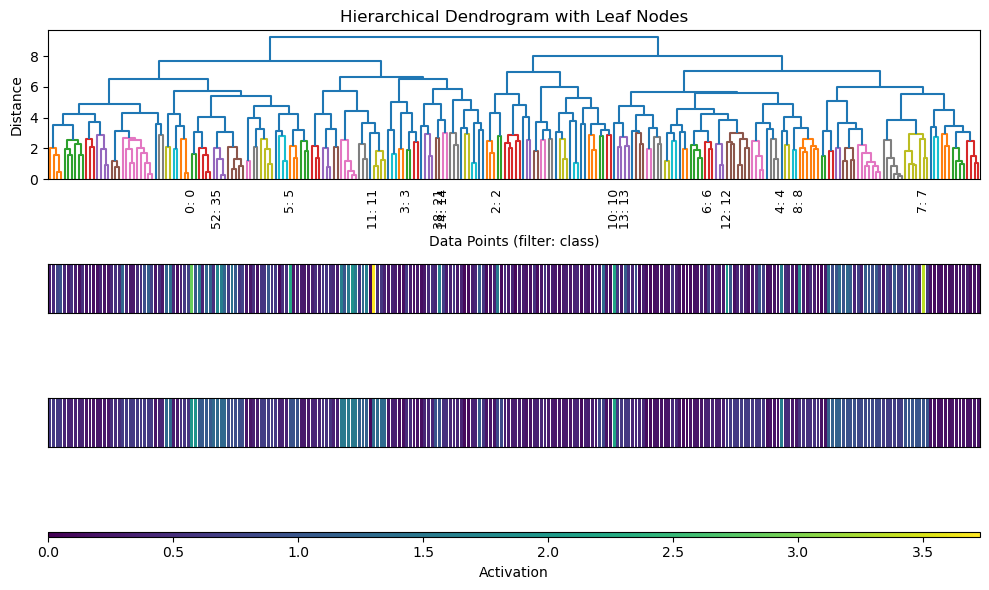

In [3184]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.cm as cm

# Load the correlation matrix from a file
# correlation_matrix = load_correlation_matrix_from_file()

# Changeables
height_threshold = 3 #3.4 #2 #5.5 #2.4 #2  # Adjust this threshold as needed

# top15 list of leaf IDs
#top15 = [32, 28, 59, 30, 4, 45, 9, 23, 51, 34, 40, 42, 10, 16, 20]
#top15 = [20, 43, 8, 42, 7, 44, 47, 13, 52, 61, 55, 23, 62, 48, 28]   # f32/3ds
#top15 = [39, 3, 42, 32, 15, 20, 62, 35, 46, 24, 11, 14, 57, 16, 8]    # f16/4ds/jepa2
top15 = top15_filters_era

# # Turn off seaborn styling
# import matplotlib
# matplotlib.style.use('default')

###################
# Base dendrogram #
###################
# Calculate the distance matrix from the correlation matrix
distance_matrix = 1 - correlation_matrix

# Perform hierarchical clustering
linkage = hierarchy.linkage(distance_matrix, method='complete')

# Cut the dendrogram at a certain height to obtain clustering labels
# labels = hierarchy.cut_tree(linkage, n_cluster=5, height=height_threshold).flatten()
# labels = hierarchy.cut_tree(linkage, n_clusters=5).flatten()
labels = hierarchy.cut_tree(linkage, height=height_threshold).flatten()
orderred_labels = labels[dendrogram['leaves']] 

# Plot the dendrogram
fig, (ax_dendro, ax_bars, ax_count, ax_colorbar) = plt.subplots(nrows=4, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1, 1, 0.1]})
dendrogram = hierarchy.dendrogram(linkage, no_labels=False, color_threshold=height_threshold, ax=ax_dendro)

# Set the title, x-label, and y-label for the dendrogram
ax_dendro.set_title('Hierarchical Dendrogram with Leaf Nodes')
ax_dendro.set_xlabel('Data Points')
ax_dendro.set_ylabel('Distance')

# Add leaf IDs to the x-axis labels if they are in the top15 list
xticklabels = ax_dendro.get_xticklabels()
for i, filter in enumerate(dendrogram['leaves']):
    if filter in top15:
        ## without class label
        #xticklabels[i] = f'{filter}'

        # with class label
        class_label = orderred_labels[i]
        xticklabels[i] = f'{filter}: {class_label}'
    else:
        xticklabels[i] = ''

# Set the font size for the tick labels on the x-axis
ax_dendro.set_xticklabels(xticklabels, fontsize=9)



###############
# Activations #
###############
# Plot the leaf nodes with corresponding colors based on activations_vector
leaf_colors = labels[dendrogram['leaves']]
bar_colors = plt.cm.viridis(activations_vector[dendrogram['leaves']] / np.max(activations_vector))  # Normalize colors

# Get the number of leaf nodes
num_leaf_nodes = len(leaf_colors)

# Plot the bar graph with stretched length and color based on activations_vector
ax_bars.bar(range(num_leaf_nodes), np.ones(num_leaf_nodes), color=bar_colors)
ax_bars.set_xlim(-0.5, num_leaf_nodes - 0.5)
ax_bars.set_ylim(bottom=0, top=1.0)
ax_bars.set_xticks([])
ax_bars.set_yticks([])

# Create a color bar
norm = plt.Normalize(0, np.max(activations_vector))
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis), cax=ax_colorbar, orientation='horizontal')
cbar.set_label('Activation')

# Set the title, x-label, and y-label for the dendrogram
ax_dendro.set_title('Hierarchical Dendrogram with Leaf Nodes')
ax_dendro.set_xlabel('Data Points (filter: class)')
ax_dendro.set_ylabel('Distance')



####################
# Group membership #
####################
# Get unique values and their counts
unique_values, counts = np.unique(labels, return_counts=True)
#expanded_unique_value_counts = [counts[unique_values==label][0] for label in labels]
expanded_unique_value_counts = np.array([np.count_nonzero(labels == label) for label in orderred_labels])
#selected_values = expanded_unique_value_counts[expanded_unique_value_counts > 0]

print(labels)
#print(unique_values)
print(expanded_unique_value_counts, len(expanded_unique_value_counts))


# Calculate the average activations_vector for each class label
average_activations_by_class = np.bincount(orderred_labels, weights=activations_vector[dendrogram['leaves']]) / np.bincount(orderred_labels)

# Create a simple list with elements repeated based on the corresponding label
expanded_average_activations = average_activations_by_class[orderred_labels]

# Prepare selected_values and bar_colors for ax_count
selected_indices = [idx for idx, val in enumerate(labels) if val in expanded_unique_value_counts]
selected_bars = bar_colors[selected_indices]

# Plot the leaf nodes with corresponding colors based on activations_vector
leaf_colors = labels[dendrogram['leaves']]
bar_colors = plt.cm.viridis(expanded_average_activations / np.max(activations_vector))  # Normalize colors


# block out some bars
#selected_indices = [idx for idx, val in enumerate(expanded_unique_value_counts) if val >= 8 and activations_vector[idx]> 2]
selected_indices = [idx for idx, val in enumerate(expanded_average_activations)]
selected_bars = bar_colors[selected_indices*10]

# plot
ax_count.bar(selected_indices, np.ones(len(selected_indices)), color=selected_bars)

#ax_count.set_xlim(ax_bars.get_xlim())  # Match x-limits with ax_bars
ax_count.set_xlim(-0.5, num_leaf_nodes - 0.5)

ax_count.set_ylim(bottom=0, top=1.0)
ax_count.set_xticks([])
ax_count.set_yticks([])
        
plt.tight_layout()
plt.show()


### multi-filter subs


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)
  import sys



STORM INDEX: 0
(18, 64, 64)
FILTERS [0, 173]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


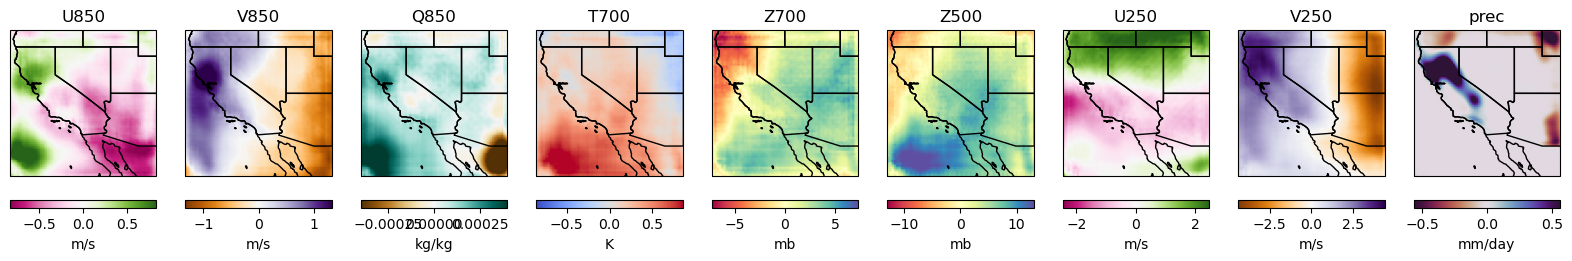

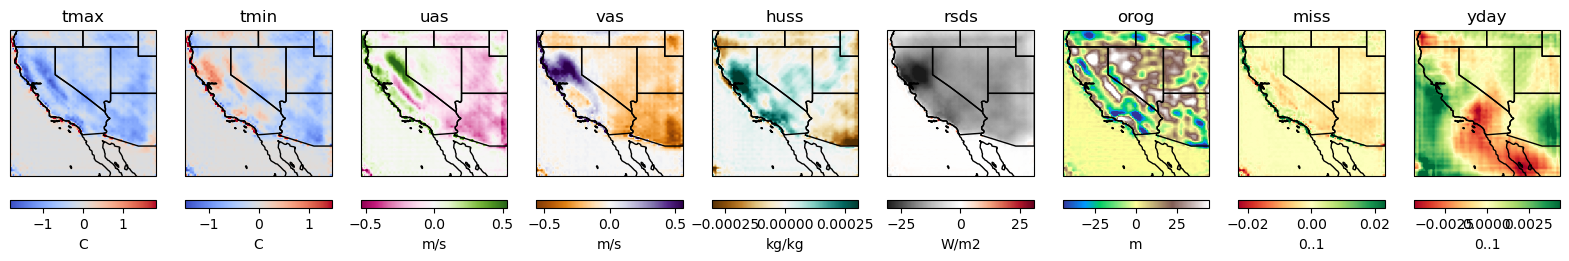

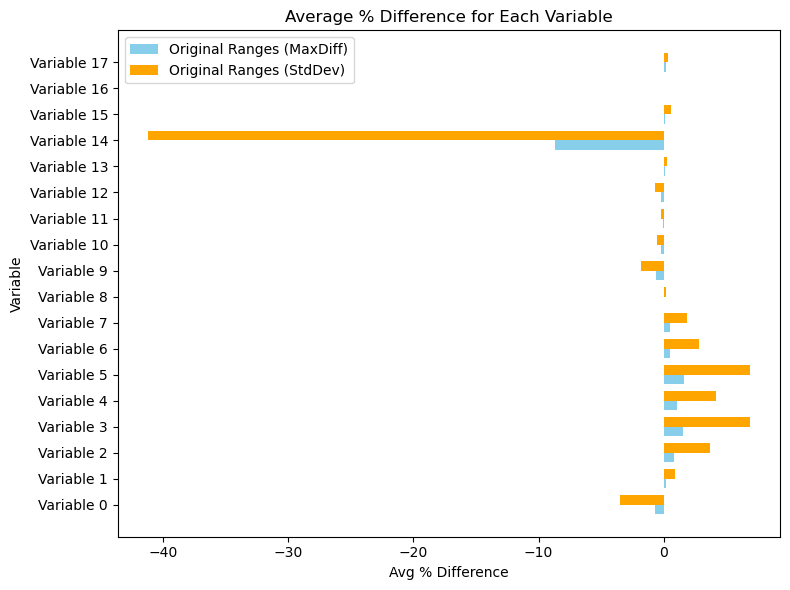


STORM INDEX: 0
(18, 64, 64)
FILTERS [137, 52, 67, 249]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


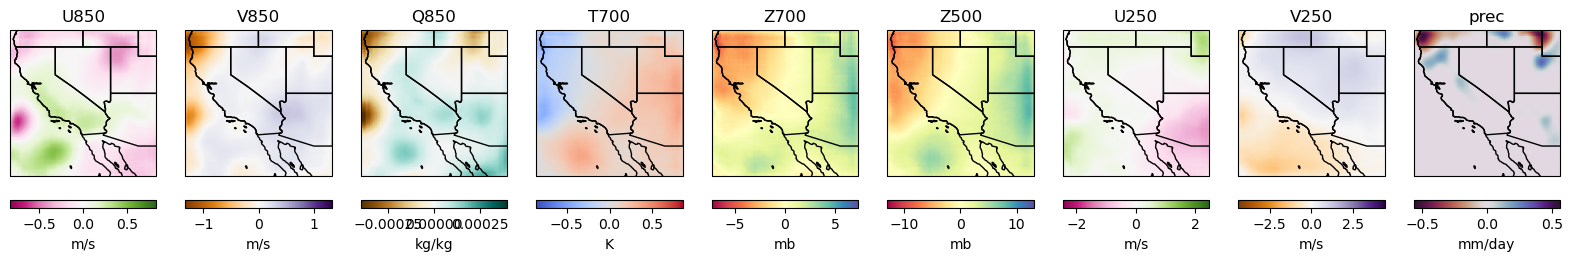

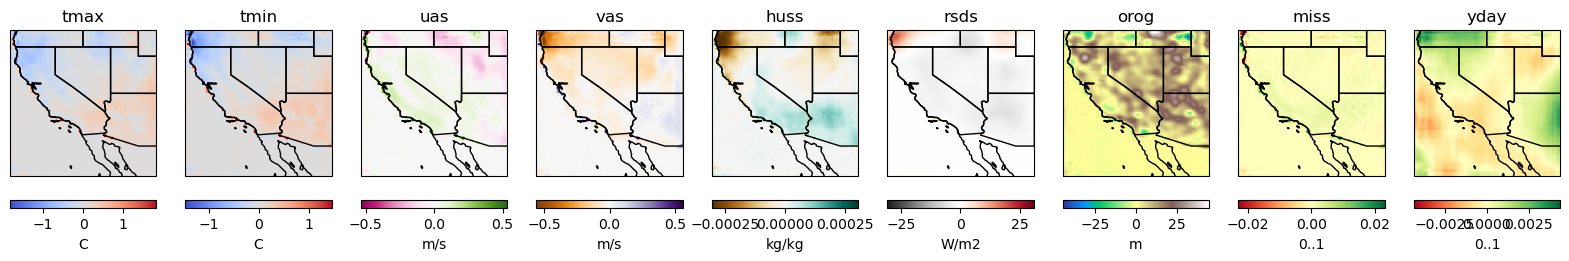

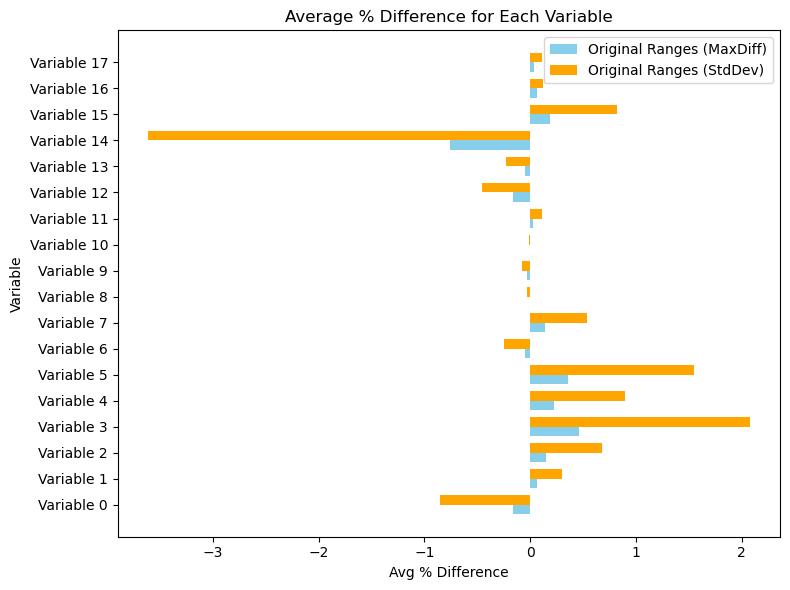


STORM INDEX: 1
(18, 64, 64)
FILTERS [137, 52, 67, 249]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


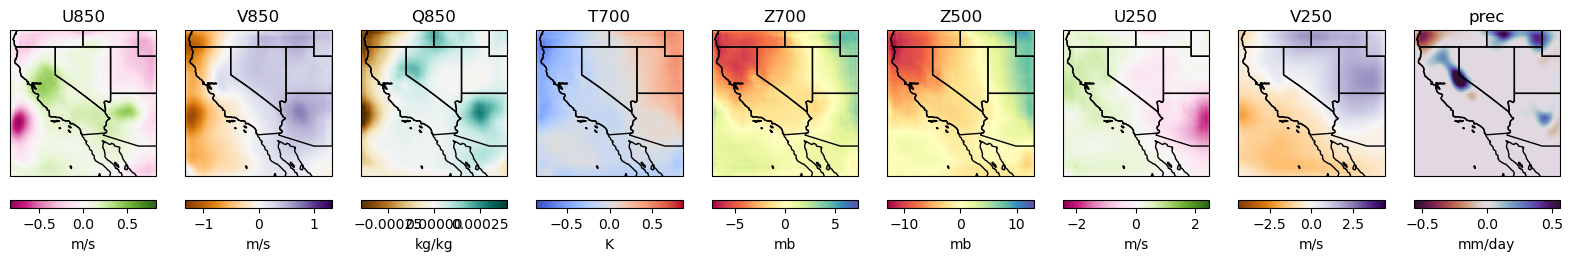

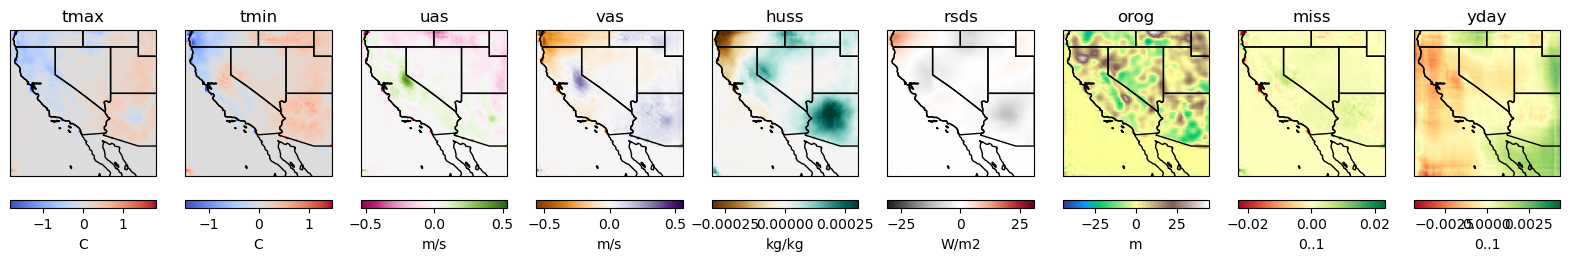

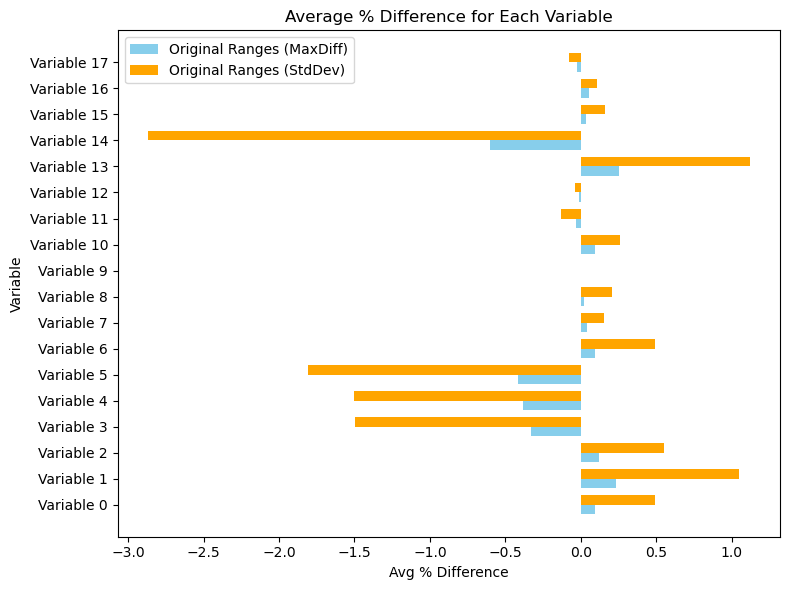


STORM INDEX: 2
(18, 64, 64)
FILTERS [137, 52, 67, 249]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


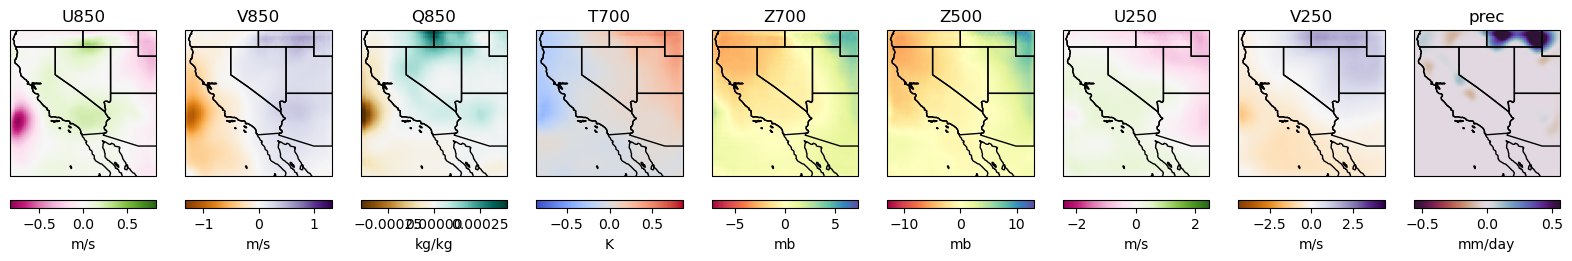

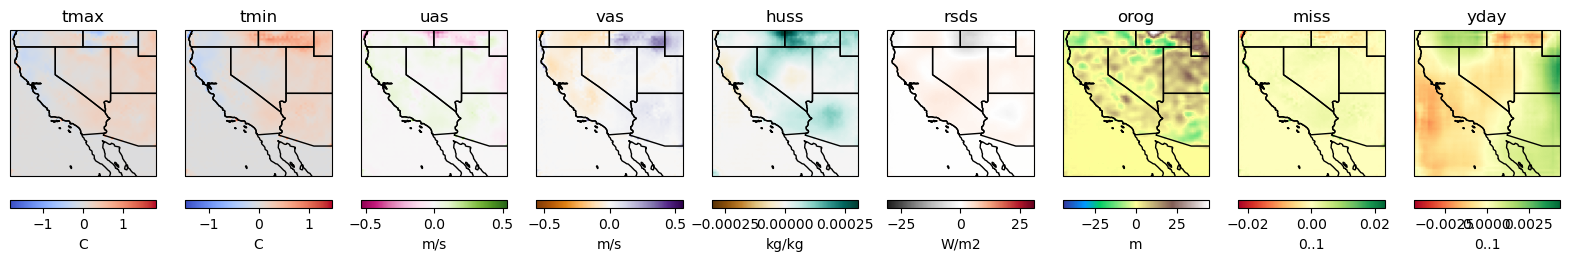

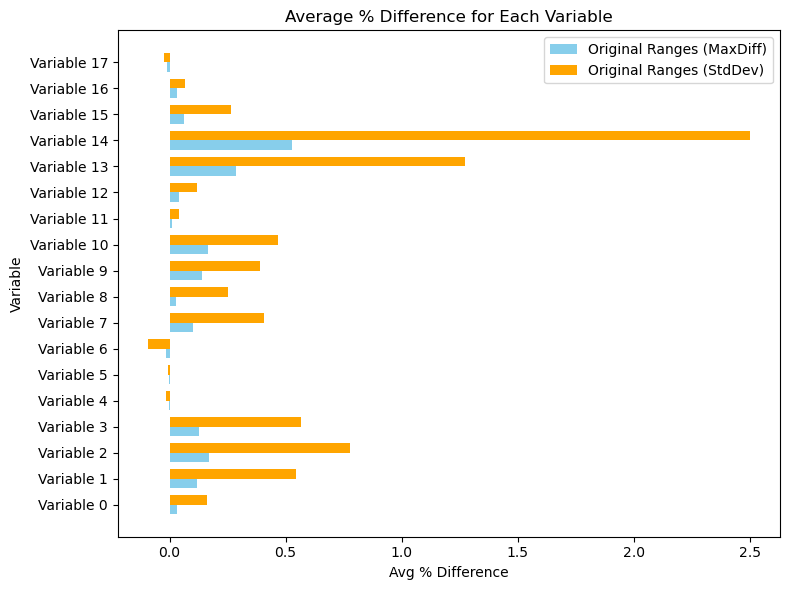


STORM INDEX: 3
(18, 64, 64)
FILTERS [137, 52, 67, 249]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


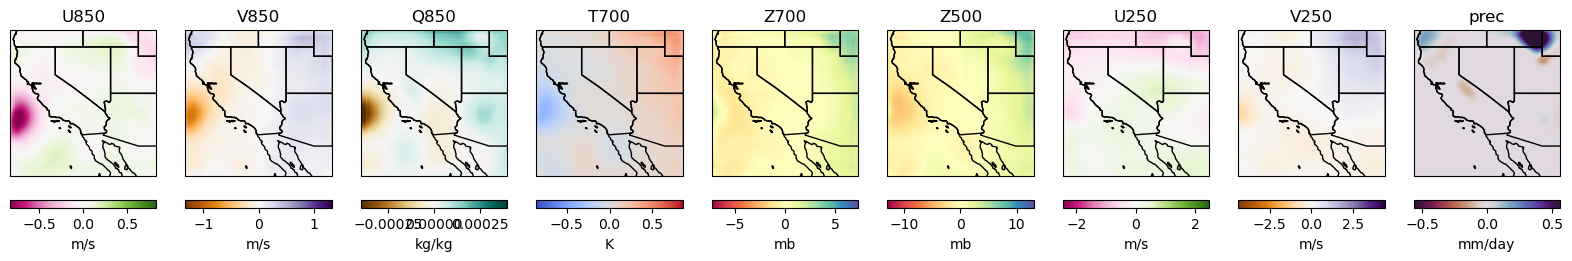

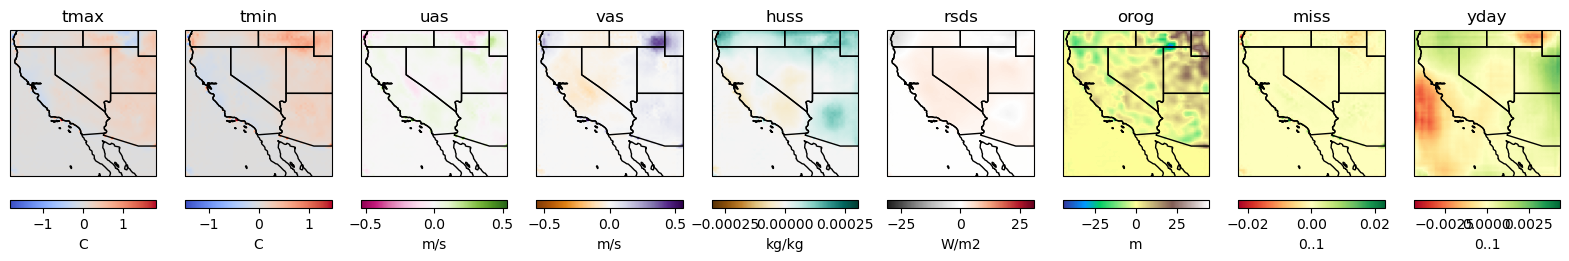

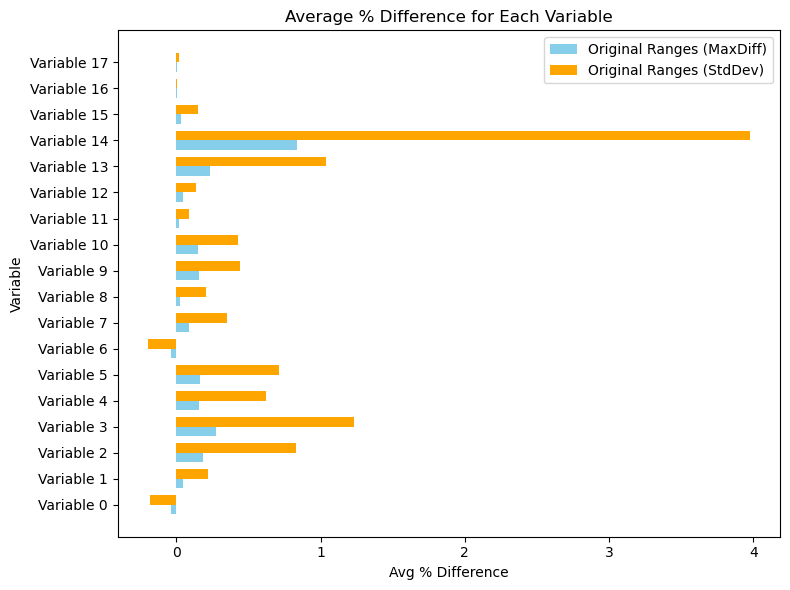


STORM INDEX: 0
(18, 64, 64)
FILTERS [11, 30, 26, 189]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


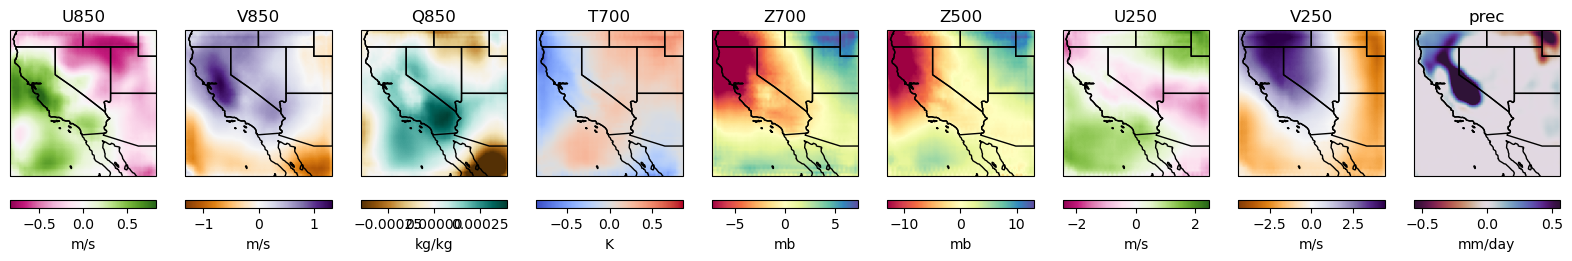

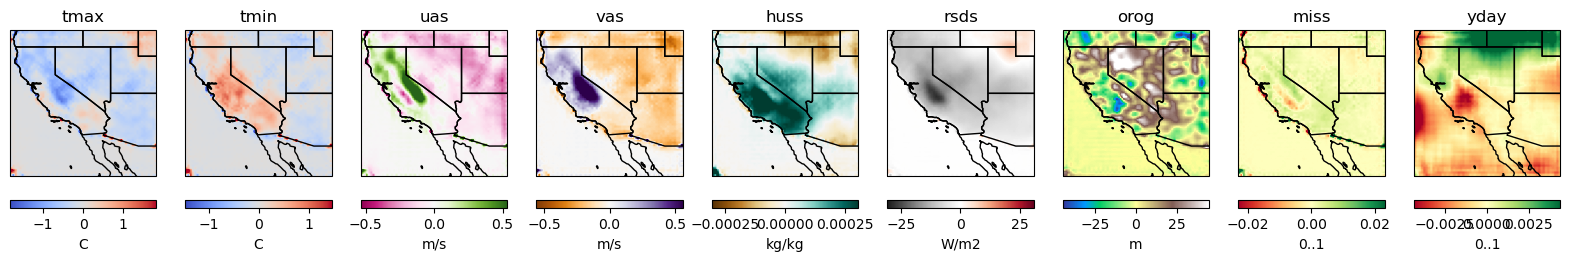

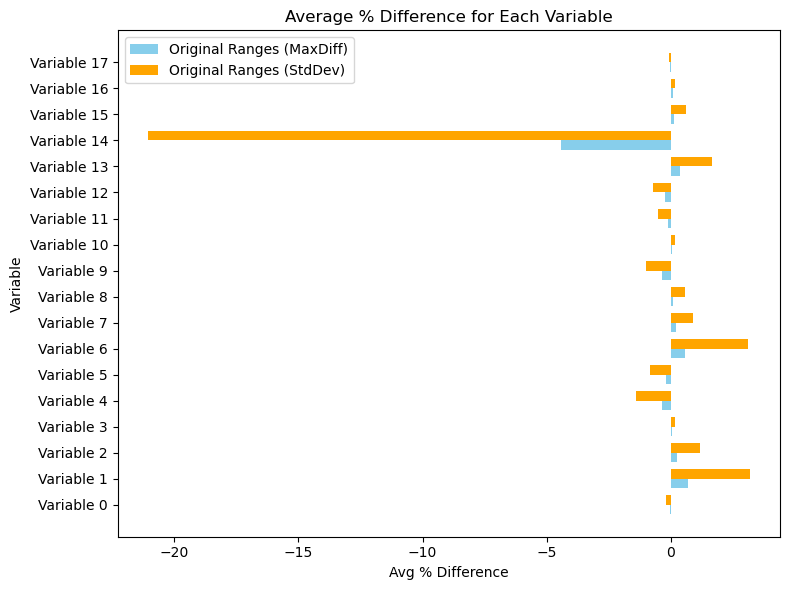


STORM INDEX: 0
(18, 64, 64)
FILTERS [14, 240]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


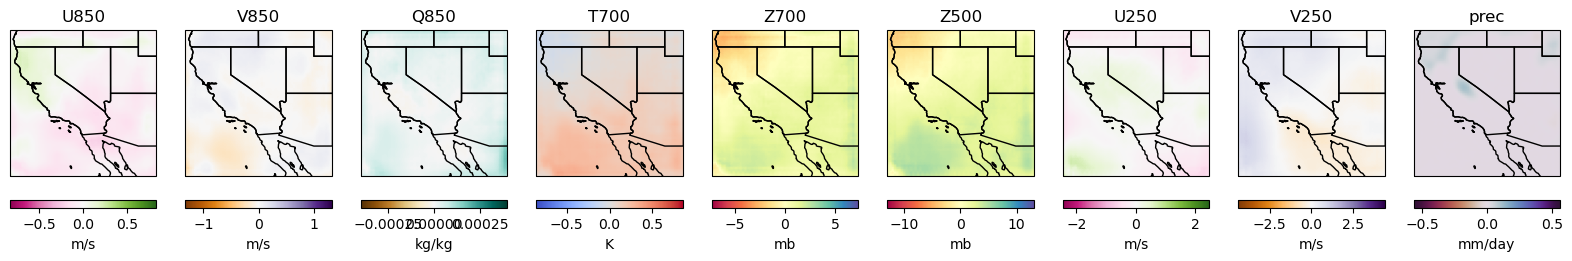

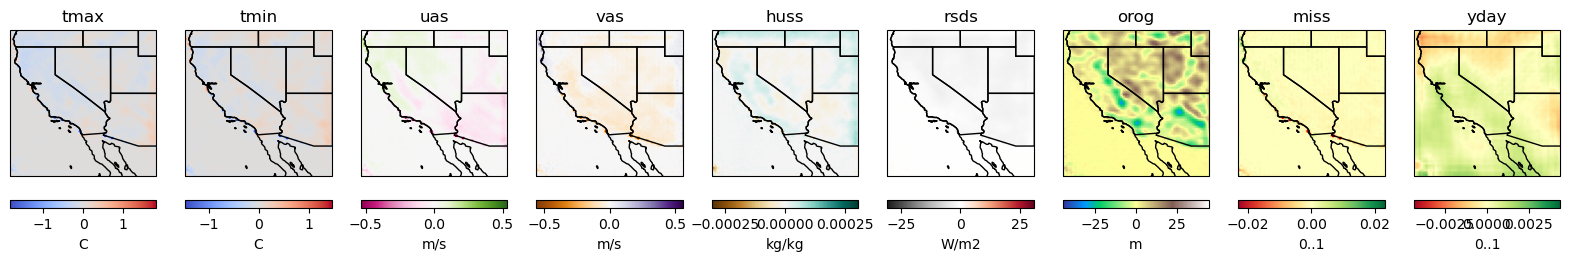

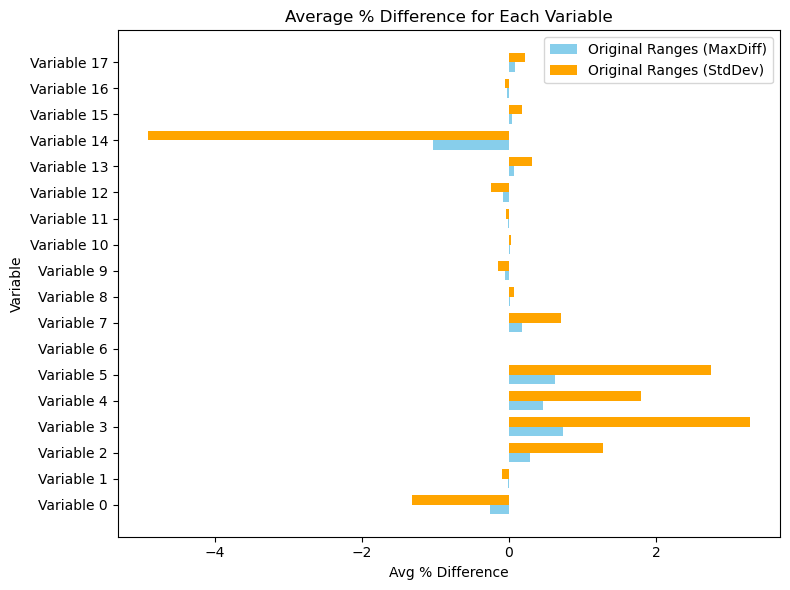


STORM INDEX: 0
(18, 64, 64)
FILTERS [10]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


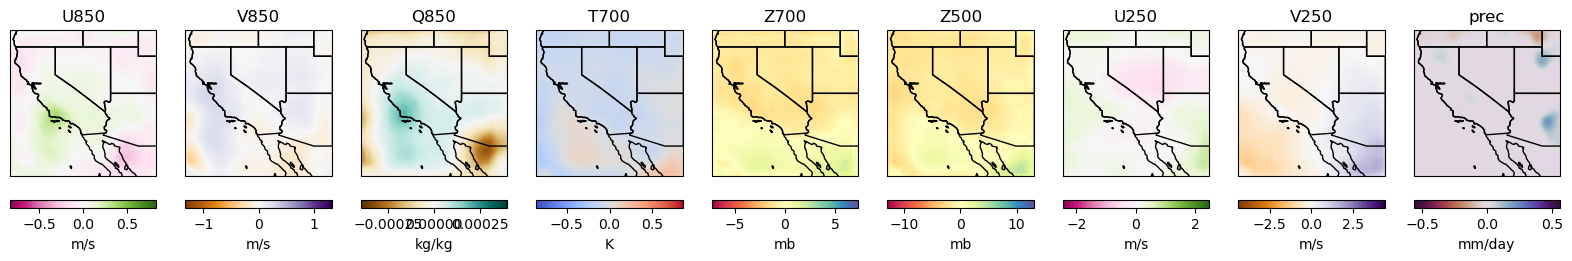

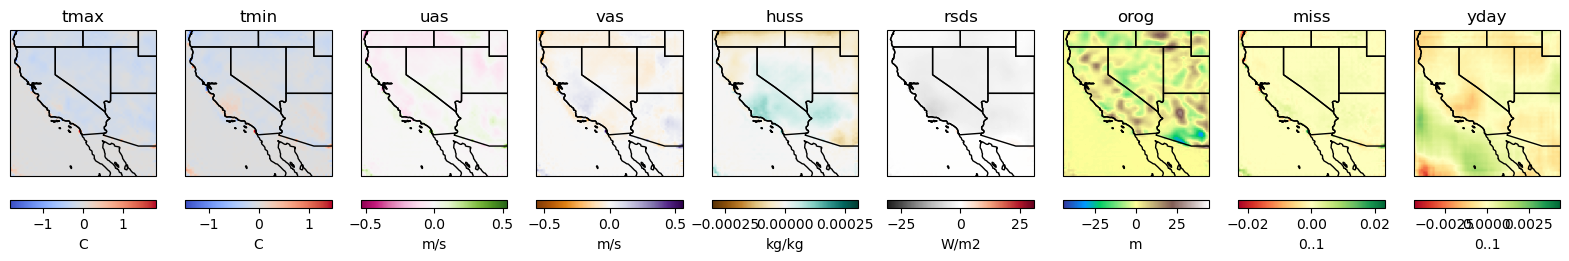

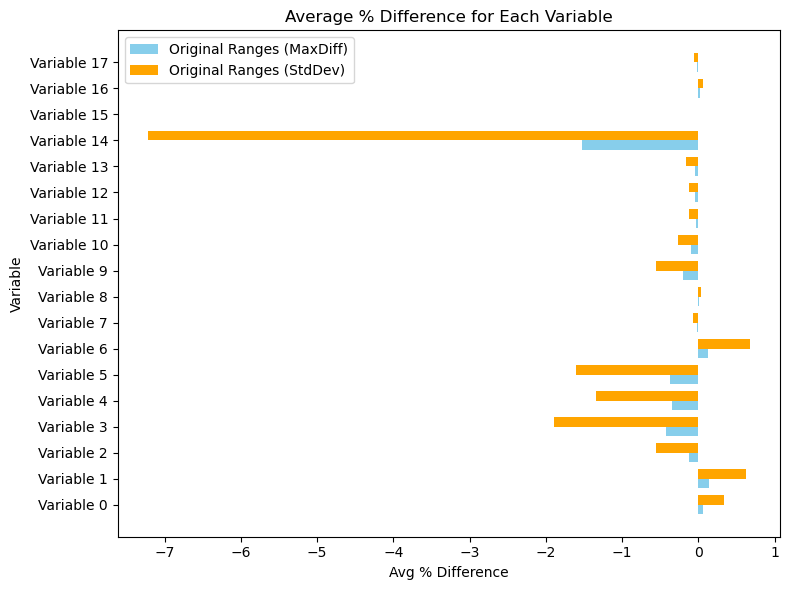


STORM INDEX: 0
(18, 64, 64)
FILTERS [12, 198, 241, 48, 115, 42, 192]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


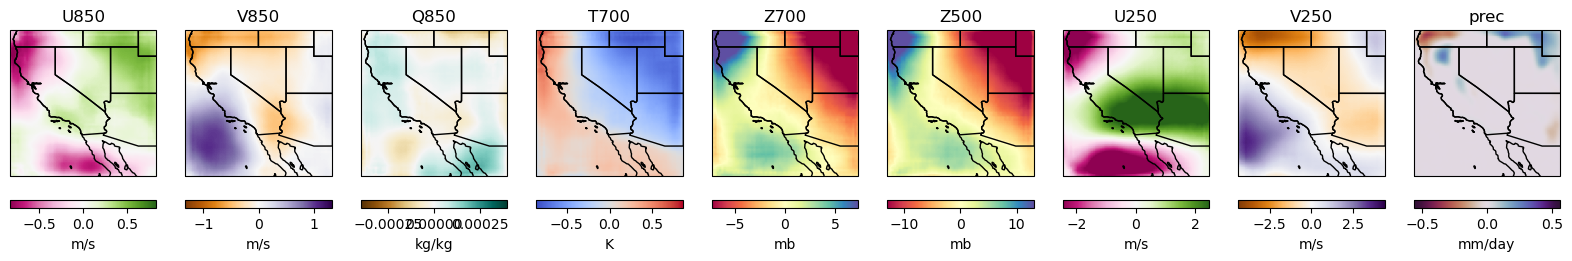

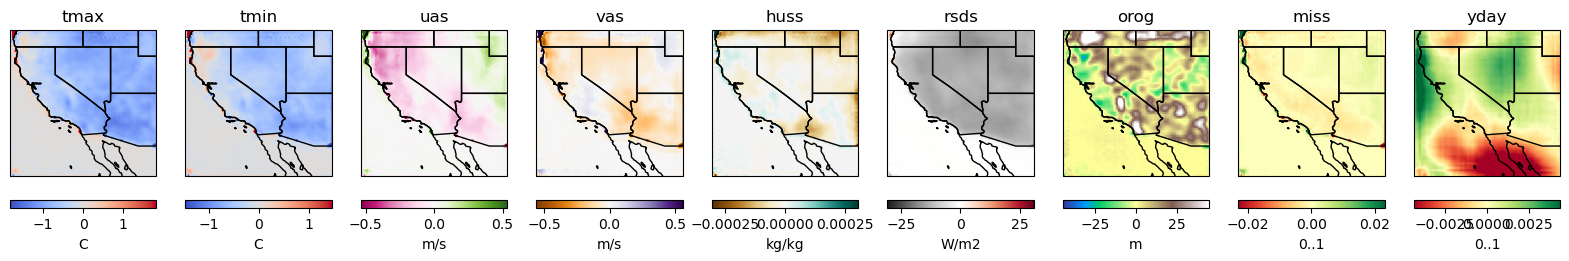

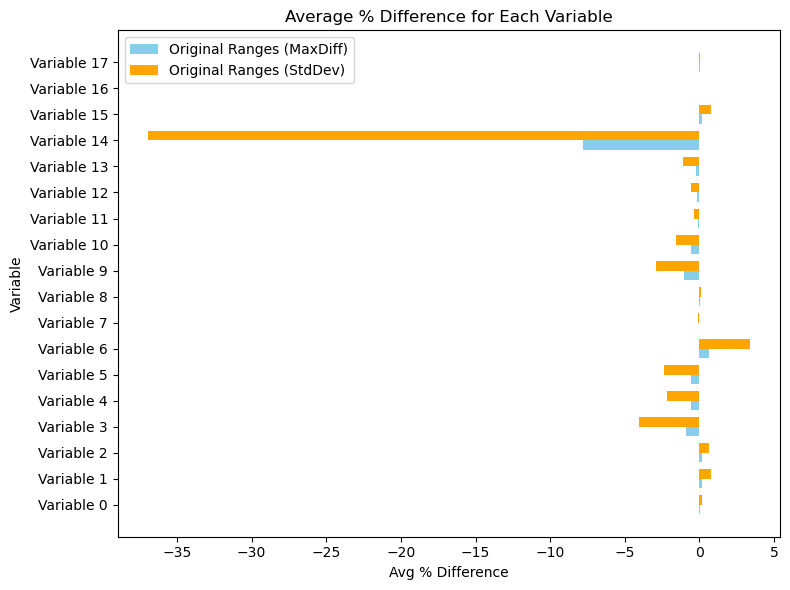


STORM INDEX: 0
(18, 64, 64)
FILTERS [157, 63, 22, 46, 84, 7, 127]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


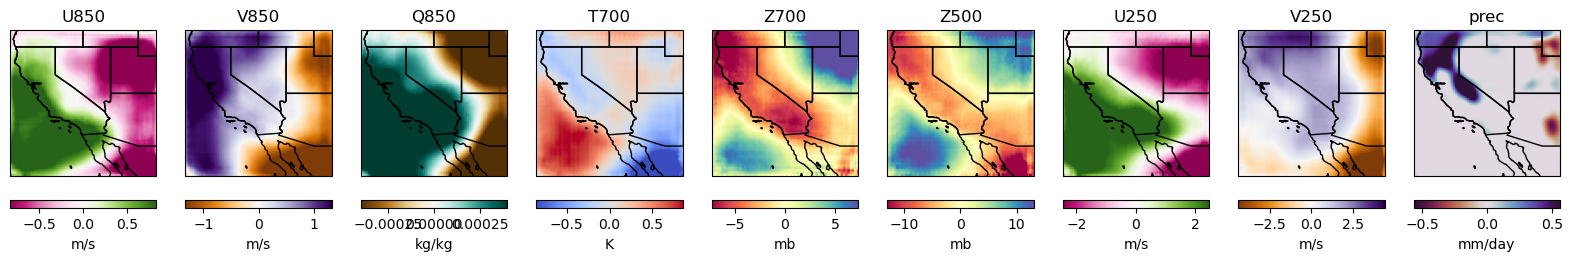

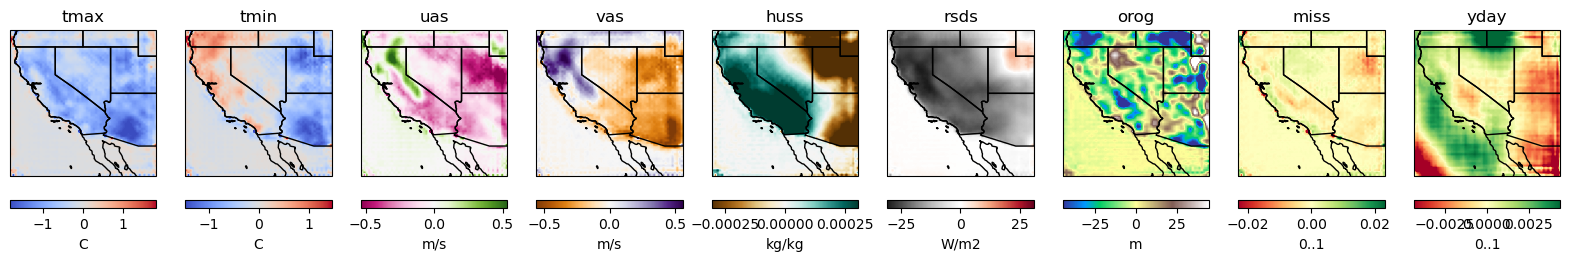

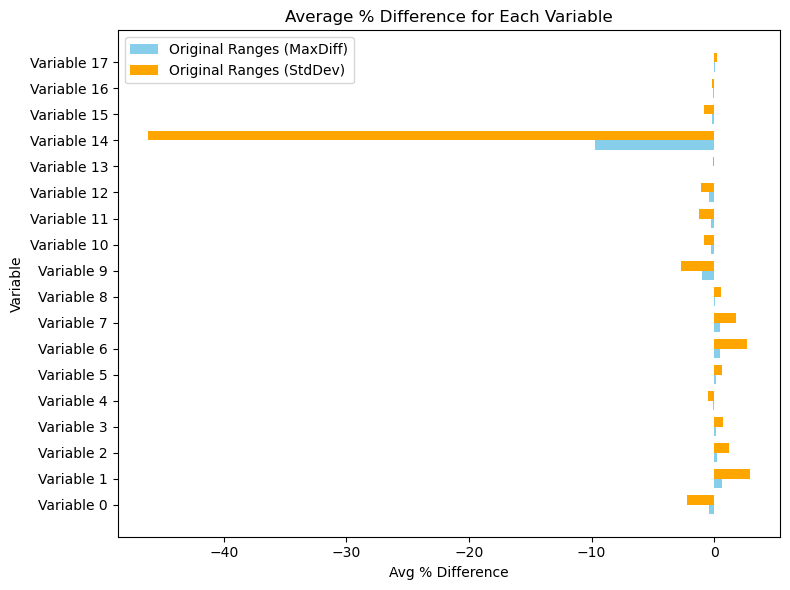

([-0.8316131445316253,
  -1.2178470726615203,
  -0.0003133399378915756,
  -0.6086961784627571,
  -7.311604443373133,
  -10.506357224992447,
  -1.9633346241734042,
  -3.8761256935258004,
  -0.4739536400734916,
  -1.8326795138433598,
  -1.4624337652791135,
  -0.5336992237003686,
  -0.5428658390527927,
  -0.0002189763425687292,
  -30.895340850011834,
  -34.7508867193309,
  -0.021877250670518007,
  -0.004013412055338053],
 [0.6175744167520647,
  1.324801794542367,
  0.0003976431240136824,
  0.8544938021836632,
  6.878168169682543,
  13.002233042424887,
  2.4582552034982106,
  4.398260995351407,
  0.5628076739363415,
  1.1906709087337972,
  1.3082534060975457,
  0.502731868771243,
  0.5571838709446868,
  0.0003043953909236065,
  9.073350014093295,
  44.43150104248658,
  0.02313950952909934,
  0.004354749214472767])

In [3193]:
#apply_filter_substitutions(storms, [0, 1, 2], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b)
vmin,vmax = get_filter_substitutions_minmax(storms, [0, 173], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 26)
apply_filter_substitutions(storms, [0, 173], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 1, vmin=vmin, vmax=vmax)
apply_filter_substitutions(storms, [137, 52, 67, 249], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 4, vmin=vmin, vmax=vmax)
apply_filter_substitutions(storms, [11, 30, 26, 189], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 1, vmin=vmin, vmax=vmax)
apply_filter_substitutions(storms, [14, 240], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 1, vmin=vmin, vmax=vmax)
apply_filter_substitutions(storms, [10], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 1, vmin=vmin, vmax=vmax)
apply_filter_substitutions(storms, [12, 198, 241, 48, 115, 42, 192], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 1, vmin=vmin, vmax=vmax)
apply_filter_substitutions(storms, [157, 63, 22, 46, 84, 7, 127], calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b, 1, vmin=vmin, vmax=vmax)



#apply_filter_substitutions(storms, [111, 7, 81, 94, 241, 39, 141, 100, 29, 12, 125, 70, 162, 222, 240, 183, 185, 231, 236, 87, 47, 119, 48, 82, 107, 101, 113, 74, 91, 23, 128, 126, 173, 202, 220, 36, 57, 242, 83, 175, 127, 164, 146, 234, 33, 174, 195, 212, 15, 21, 201, 215, 79, 157, 177, 11, 142, 85, 88, 253, 32, 151, 192, 92, 136, 77, 40, 67, 147, 163, 114, 211, 102, 224]
#, calc_filter_variance, plot_9v_192x256, bn_mean_era, gen_b)
